# Graph cut method for bloodcells counting

A ot of thanks for contribution to Paweł :)

Example 2: JPG image with more yellowish background - it does not need adaptive approach. That it there are good enough results for fixed parameters for flow treshold.

In [1]:
from PIL import Image
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
from scipy.stats import norm
from networkx.algorithms.flow import edmonds_karp

Necessary functions for pipeline:

In [2]:
def get_distribution(image):
    im_data = np.array(image.getchannel('G'),dtype='int64')
    im_data = im_data.reshape(im_data.shape[0] * im_data.shape[1], 1)
    mu, std = norm.fit(im_data)
    return mu, std

def get_bitmap(R, threshold, dimx, dimy):
    bitmap = np.zeros((dimx, dimy))
    for i in range(dimx):
        for j in range(dimy):
            if R['s'][(i,j)]['flow'] > threshold:
                bitmap[i][j] = 1
    return bitmap

def create_graph(arr, mu, std, k, s):
    G = nx.DiGraph()
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            G.add_node((i,j))
    G.add_node('s')
    G.add_node('t')
    for y in range(arr.shape[1]):
        for x in range(arr.shape[0]):
            if x > 0:
                G.add_edge((x,y),(x-1,y),capacity=(k * np.exp((abs(arr[x,y] - arr[x-1,y])) ** 2 / s)))
                G.add_edge((x-1,y),(x,y),capacity=(k * np.exp((abs(arr[x,y] - arr[x-1,y])) ** 2 / s)))
            if y > 0:
                G.add_edge((x,y),(x,y-1),capacity=(k * np.exp((abs(arr[x,y] - arr[x,y-1])) ** 2 / s)))
                G.add_edge((x,y-1),(x,y),capacity=(k * np.exp((abs(arr[x,y] - arr[x,y-1])) ** 2 / s)))
            G.add_edge((x,y),'t',capacity=(1 - norm(mu, std).pdf(arr[x,y])))
            G.add_edge('s',(x,y),capacity=(norm(mu, std).pdf(arr[x,y])))
    return G

Pipeline:

In [6]:
def image_processing_pipeline(image):
    
    # image is an opened picture
    image_arr = np.array(image,dtype='int64')
    
    width, height, depth = image_arr.shape
    
    result_image = np.zeros((width, height, depth))
    
    # find a fitting distribution for background
    mu, std = get_distribution(image)
    
    w_coords = list(range(0, width, 32))
    h_coords = list(range(0, height, 32))
    
    if w_coords[-1] != width - 1:
        w_coords.append(width - 1)
    if h_coords[-1] != height - 1:
        h_coords.append(height - 1)

    for d in range(depth):
        # we split the image into 32x32 subimages
        for w in range(len(w_coords) - 1): # not considering last element
            for h in range(len(h_coords) - 1):
                arr = image_arr[w_coords[w]:w_coords[w+1], h_coords[h]:h_coords[h+1], d]
                
                G = create_graph(arr, mu, std, 0.0004, 4)
                
                R = edmonds_karp(G, 's', 't')
                
                print('Current flow:', R.graph['flow_value'], end=' ')
                
                dimx = w_coords[w+1] - w_coords[w]
                dimy = h_coords[h+1] - h_coords[h]
                bitmap = get_bitmap(R, 0.008, dimx, dimy)
                
                arr2 = arr * bitmap
                
                result_image[w_coords[w]:w_coords[w+1], h_coords[h]:h_coords[h+1], d] = arr2
                
                print('Slice {}:{},{}:{},{} done!'.format(w_coords[w], w_coords[w+1], h_coords[h], h_coords[h+1], d))

    return result_image

In [7]:
image = Image.open('3958.jpg').resize((200,200))
result = image_processing_pipeline(image)

Current flow: 7.706688699100617 Slice 0:32,0:32,0 done!
Current flow: 7.584717089768661 Slice 0:32,32:64,0 done!
Current flow: 7.652996362838561 Slice 0:32,64:96,0 done!
Current flow: 7.693546683077554 Slice 0:32,96:128,0 done!
Current flow: 7.551227209761108 Slice 0:32,128:160,0 done!
Current flow: 7.566272131977162 Slice 0:32,160:192,0 done!
Current flow: 1.709633941308457 Slice 0:32,192:199,0 done!
Current flow: 7.711295411281125 Slice 32:64,0:32,0 done!
Current flow: 8.174187265592003 Slice 32:64,32:64,0 done!
Current flow: 7.93014464373135 Slice 32:64,64:96,0 done!
Current flow: 7.430699604177442 Slice 32:64,96:128,0 done!
Current flow: 7.826311538861241 Slice 32:64,128:160,0 done!
Current flow: 7.566081351618593 Slice 32:64,160:192,0 done!
Current flow: 1.6063358665763423 Slice 32:64,192:199,0 done!
Current flow: 7.896178783291715 Slice 64:96,0:32,0 done!
Current flow: 7.782616461056536 Slice 64:96,32:64,0 done!
Current flow: 7.720049444850377 Slice 64:96,64:96,0 done!
Current fl

Current flow: 7.543166230900422 Slice 160:192,160:192,2 done!
Current flow: 1.868913123534247 Slice 160:192,192:199,2 done!
Current flow: 1.5212222330543348 Slice 192:199,0:32,2 done!
Current flow: 1.5014264080060435 Slice 192:199,32:64,2 done!
Current flow: 1.3070054494368397 Slice 192:199,64:96,2 done!
Current flow: 1.703638479070625 Slice 192:199,96:128,2 done!
Current flow: 1.7062651167859175 Slice 192:199,128:160,2 done!
Current flow: 1.489908186213123 Slice 192:199,160:192,2 done!
Current flow: 0.3704854671409616 Slice 192:199,192:199,2 done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


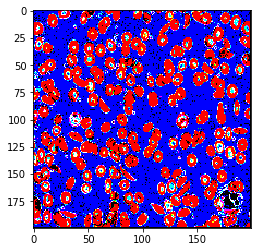

In [8]:
plt.imshow(result)